In [1]:
import pandas as pd
import censusdata
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sb

%matplotlib inline
%config InlineBackend.figure_format ='retina'

from config import *

#Load states shapefile (for plotting) (https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html under States)

statesShp = gpd.read_file(dataFolder + "/cb_2018_us_state_500k.zip").to_crs(3857)
statesShp = statesShp[['GEOID', 'STUSPS', 'NAME', 'geometry']]

def plotUS():
    ax = statesShp.plot(figsize=(20, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.5e7, -0.7e7)
    plt.ylim(2.5e6, 7e6)
    return ax

def plotTX():
    ax = statesShp[statesShp['STUSPS'] == 'TX'].plot(figsize=(10, 10), color='#e4e4e4', edgecolor='black', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.23e7, -1e7)
    plt.ylim(2.5e6, 5e6)
    return ax

def plotDFW():
    ax = statesShp[statesShp['STUSPS'] == 'TX'].plot(figsize=(50, 50), color='#fafafa', edgecolor='lightgrey', linewidth=2)
    ax.axis('equal')
    plt.xlim(-1.12e7, -1.02e7)
    plt.ylim(3.7e6, 4.1e6)
    return ax

In [2]:
year = '20'
metroId = 19100 # DFW

In [3]:
bgrps = gpd.read_file(dataFolder + 'tl_2020_48_bg.zip').to_crs(3857)

In [4]:
bgrps = bgrps[['GEOID', 'COUNTYFP', 'ALAND', 'geometry']].copy()
bgrps['GEOID'] = bgrps['GEOID'].astype(int)
bgrps['COUNTYFP'] = bgrps['COUNTYFP'].astype(int)

In [5]:
bgrps

,GEOID,COUNTYFP,ALAND,geometry
0,481539506003,153,9238641,"POLYGON ((-11285239.429 4026685.683, -11285236..."
1,481539506005,153,1070676551,"POLYGON ((-11306112.166 4036819.664, -11306045..."
2,481610004001,161,12766486,"POLYGON ((-10741933.817 3736605.570, -10741839..."
3,481610006001,161,153883256,"POLYGON ((-10733577.283 3722195.688, -10733521..."
4,481759602001,175,391287006,"POLYGON ((-10870789.948 3344361.764, -10870776..."
...,...,...,...,...
18633,482211602161,221,8063739,"POLYGON ((-10892640.442 3829503.749, -10892583..."
18634,482211603031,221,1542092,"POLYGON ((-10888726.928 3818638.273, -10888726..."
18635,480459502002,45,2320609023,"POLYGON ((-11295820.004 4089216.426, -11295814..."
18636,482870001004,287,104544628,"POLYGON ((-10827269.022 3550986.521, -10827136..."


In [6]:
xwalk = pd.read_pickle(dataFolder + "/xwalk_data_combined.pkl")

In [7]:
dfwCounties = set(xwalk[xwalk['cbsa'] == metroId].groupby('ctyname').first()['bgrp'] // 10**7 % 10**3)
dfwCounties

{85, 113, 121, 139, 231, 251, 257, 367, 397, 439, 497}

In [8]:
dfwBgrps = bgrps[bgrps['COUNTYFP'].isin(dfwCounties)]

In [9]:
dfwBgrps

,GEOID,COUNTYFP,ALAND,geometry
22,480850307025,85,1113614,"POLYGON ((-10757776.282 3921721.186, -10757756..."
23,480850316212,85,1076314,"POLYGON ((-10774233.821 3897573.678, -10774233..."
28,480850307021,85,528137,"POLYGON ((-10755768.631 3922558.397, -10755765..."
29,480850316281,85,392195,"POLYGON ((-10766955.738 3902221.690, -10766953..."
30,480850317111,85,565626,"POLYGON ((-10780623.127 3894954.119, -10780622..."
...,...,...,...,...
18589,484391107053,439,720494,"POLYGON ((-10850777.833 3865418.544, -10850773..."
18590,484391107051,439,795308,"POLYGON ((-10849958.189 3864517.623, -10849866..."
18591,484391107041,439,680602,"POLYGON ((-10849223.705 3862180.054, -10849221..."
18592,484391107052,439,772016,"POLYGON ((-10850986.447 3864368.824, -10850962..."


In [10]:
odData = pd.read_pickle(dataFolder + '/od_data_combined' + year + '.pkl')

In [11]:
odData = odData.rename(columns={'S000': 'workers'})
odData['w_bgrp'] = odData['w_geocode'] // 10**3
byWork = odData[['w_bgrp', 'workers']].groupby('w_bgrp').sum()
merge = pd.merge(dfwBgrps, byWork, left_on='GEOID', right_on='w_bgrp', how='left')
merge['workers'] = merge['workers'].fillna(0) #If nobody commutes here, will be nan but shoul be 0

In [12]:
merge['density'] = merge['workers'] / merge['ALAND'] * 1000_000 #People per km^2

In [13]:
gdf = merge[['ALAND', 'workers', 'density', 'geometry']]
gdf

,ALAND,workers,density,geometry
0,1113614,3474.0,3119.572850,"POLYGON ((-10757776.282 3921721.186, -10757756..."
1,1076314,88.0,81.760527,"POLYGON ((-10774233.821 3897573.678, -10774233..."
2,528137,785.0,1486.356760,"POLYGON ((-10755768.631 3922558.397, -10755765..."
3,392195,42.0,107.089586,"POLYGON ((-10766955.738 3902221.690, -10766953..."
4,565626,163.0,288.176286,"POLYGON ((-10780623.127 3894954.119, -10780622..."
...,...,...,...,...
4366,720494,291.0,403.889554,"POLYGON ((-10850777.833 3865418.544, -10850773..."
4367,795308,60.0,75.442470,"POLYGON ((-10849958.189 3864517.623, -10849866..."
4368,680602,44.0,64.648649,"POLYGON ((-10849223.705 3862180.054, -10849221..."
4369,772016,135.0,174.866842,"POLYGON ((-10850986.447 3864368.824, -10850962..."


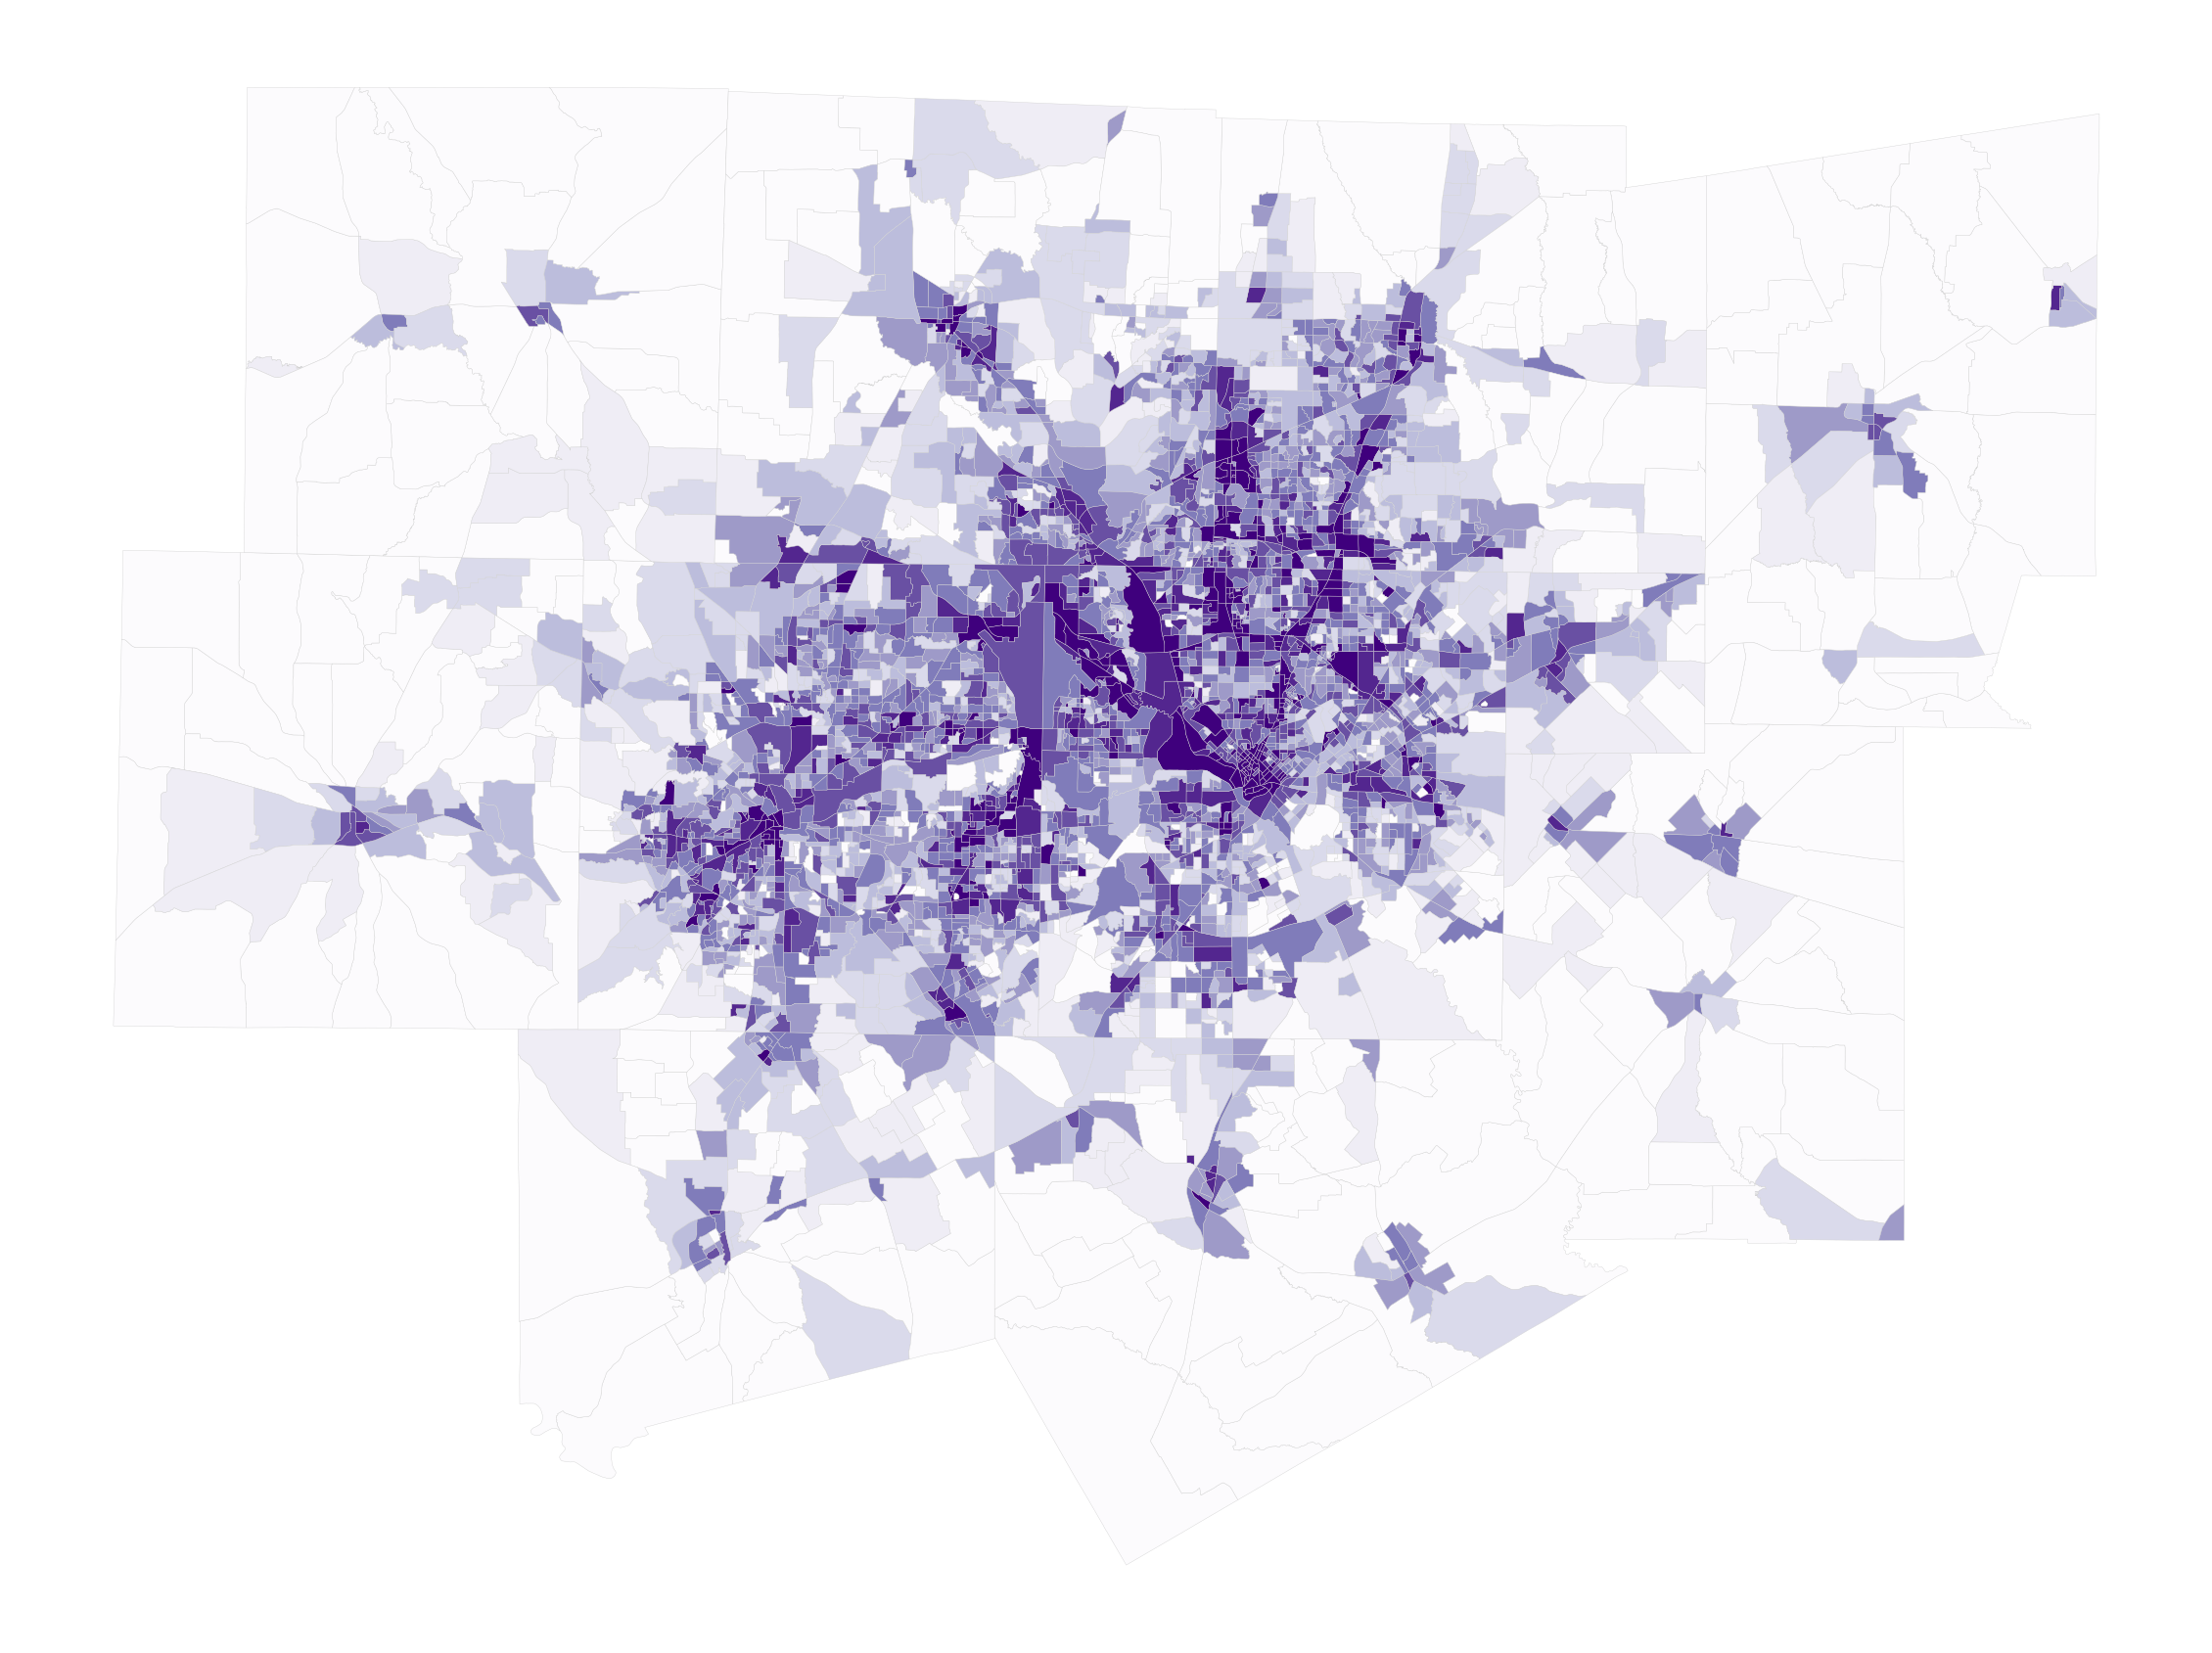

In [14]:
bins = [10, 20, 50, 100, 200, 500, 1000, 2000, np.inf]
merge.plot(column='density', scheme='UserDefined', classification_kwds={'bins': bins}, k=10, edgecolor='lightgrey', linewidth=0.2, cmap='Purples', figsize=(20, 20));
plt.axis('off')
plt.savefig('figures/workPerArea20' + year + ' lr.jpeg', dpi=100);

In [15]:
#To save to a file for ArcGis
gdf.to_file('out/work locations DFW 20' + year)
!zip -r 'out/work locations DFW 20{year}.zip' 'out/work locations DFW 20{year}'

/lustre/work/client/users/brockd/.conda/envs/ds_1300/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


  adding: out/work locations DFW 2020/ (stored 0%)
  adding: out/work locations DFW 2020/work locations DFW 2020.shp (deflated 30%)
  adding: out/work locations DFW 2020/work locations DFW 2020.shx (deflated 37%)
  adding: out/work locations DFW 2020/work locations DFW 2020.dbf (deflated 71%)
  adding: out/work locations DFW 2020/work locations DFW 2020.cpg (stored 0%)
  adding: out/work locations DFW 2020/work locations DFW 2020.prj (deflated 42%)


In [ ]:
#For multi year analysis, run above for each year
# gdf05 = gdf
# gdf10 = gdf
# gdf15 = gdf
gdf20 = gdf

In [ ]:
gdf20['diff'] = (gdf20['density'] - gdf10['density']) / gdf10['density'] * 100

In [ ]:
bins = [-100, -50, -20, -10, 0, 10, 20, 50, 100, 200, np.inf]
gdf20.plot(column='diff', scheme='UserDefined', classification_kwds={'bins': bins}, k=10, edgecolor='lightgrey', linewidth=0.2, legend=True, figsize=(20, 20));